# Assignment 2:  the perceptron


* **By Vignesh M. Pagadala**
* **Vignesh.Pagadala@colostate.edu**


## Datasets

In this assignment we will use the following datasets:
  * The [Gisette](http://archive.ics.uci.edu/ml/datasets/Gisette) handwritten digit recognition dataset. 
  * The [QSAR](http://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation) data for predicting the biochemical activity of a molecule.
  * The [Heart disease diagnosis](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) dataset.
  * For developing your code, you can use one of the scikit-learn datasets, such as the [breast cancer wisconsin dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) and the [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) toy dataset generator.
  
When writing your notebook, you can assume the datasets are in the same directory as the notebook.  Please keep the same file names as in the UCI repository.
  

## Part 1:  Variants of the perceptron algorithm 

In this assignment you will work with several variants of the perceptron algorithm:

  * The "vanila" version of the perceptron algorithm, which was introduced in class.
  * The pocket algorithm as described in the slides or page 80 in the book.
  * The **adatron** version of the perceptron described next.

In each case make sure that your implementation of the classifier **includes a bias term** (in slide set 2 and page 7 in the book you will find guidance on how to add a bias term to an algorithm that is expressed without one).

## The adatron 

Before we get to the adatron, we will derive an alternative form of the perceptron algorithm --- the dual perceptron algorithm.  All we need to look at is the weight update rule:

$$\mathbf{w} \rightarrow \mathbf{w} + \eta y_i \mathbf{x}_i.$$

This is performed whenever example $i$ is misclassified by the current weight vector.  The thing to notice, is that the weight vector is always a weighted combination of the training examples since it is that way to begin with, and each update maintains that property.  So in fact, rather than representing $\mathbf{w}$ explicitly, all we need to do is to keep track of how much each training example is contributing to the value of the weight vector, i.e. we will express it as:

$$\mathbf{w} = \sum_{i=1}^N \alpha_i y_i \mathbf{x}_i,$$

where $\alpha_i$ are positive numbers that describe the magnitude of the contribution $\mathbf{x}_i$ is making to the weight vector, and $N$ is the number of training examples.

Therefore to initialize $\mathbf{w}$ to 0, we simply initialize $\alpha_i = 0$ for $i = 1,\ldots,N$.  When expressed using the variables $\alpha_i$, the perceptron update rule becomes:

$$\alpha_i = \alpha_i + \eta y_i,$$

and you can always retrieve the weight vector using its expansion in terms of the $\alpha_i$.

Now we're ready for the adatron - the only difference is in the initialization and update equation.

Initialization:

$\alpha_i = 1$ for $i = 1,\ldots,N$

Like in the perceptron we run the algorithm until convergence, or until a fixed number of epochs has passed (an epoch is a loop over all the training data), and an epoch of training consists of the following procedure:

for each training example $i=1,\ldots,N$ perform the following steps:

1.  $\gamma = y_i * \mathbf{w}^{t} \mathbf{x}_i$
2.  $\delta\alpha = \eta * (1 - \gamma)$
3.  `if` $(\alpha_i + \delta\alpha < 0)$ : $\alpha_i = 0$, `else : ` $\alpha_i = \alpha_i + \delta\alpha$


The variable $\eta$ plays the role of the learning rate $\eta$ employed in the perceptron algorithm and $\delta \alpha$ is the proposed magnitude of change in $\alpha_i$. 
We note that the adatron tries to maintain a **sparse** representation in terms of the training examples by keeping many $\alpha_i$ equal to zero.  The adatron converges to a special case of the SVM algorithm that we will learn later in the semester; this algorithm tries to maximize the margin with which each example is classified, which is captured by the variable $\gamma$ in the algorithm (notice that the magnitude of change proposed for each $\alpha_i$ becomes smaller as $\gamma$ increases towards 1).

**Note:** if you observe an overflow issues in running the adatron, add an upper bound on the value of $\alpha_i$.

Here's what you need to do:

  - Implement the pocket algorithm and the adatron; each classifier should be implemented in a separate Python class, and use the same interface used in the code provided for the perceptron algorithm, i.e. provides the same methods with the same signature.  Make sure each classifier you use (including the original version of the perceptron) implements a bias term.
  - Compare the performance of these variants of the perceptron on the Gisette and QSAR datasets by computing an estimate of the out of sample error on a sample of the data that you reserve for testing (the test set).  In each case reserve about 60% of the data for training, and 40% for testing.  To gain more confidence in our error estimates, repeat this experiment using 10 random splits of the data into training/test sets.  Report the average error and its standard deviation in a nicely formatted table.  Is there a version of the perceptron that appears to perform better?   (In answering this, consider the differences in performance you observe in comparison to the standard deviation).



# ANSWER: #

In [174]:
import matplotlib.pyplot as plt
import numpy as np
import statistics
from astropy.table import Table, Column
import pandas as pd

## 1.a. Perceptron - Vanilla Version##

In [33]:
# Implements the perceptron algorithm, including a bias term.
class Perceptron :
    def __init__(self, max_iterations=100, learning_rate=0.2, bias = 0) :
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
        self.bias = bias
 
    def fit(self, X, y) :
        self.w = np.zeros(len(X[0]))
        # ADDING BIAS TERM
        # Change input to accomodate bias. Tack a column of 1s.
        X = np.insert(X, 0, 1, 1)
        # Include bias in weight
        self.w = np.insert(self.w, 0, self.bias)
        converged = False
        iterations = 0
        #Iterate through all datasets, and update weights based on misclassified examples.
        while (not converged and iterations <= self.max_iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * self.decision_function(X[i]) <= 0 :
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False
            iterations += 1
        self.converged = converged
        if converged :
            pass
        return self.w
 
    def decision_function(self, x) :
        return np.inner(self.w, x)
 
    def predict(self, X) :
        scores = np.inner(self.w, X)
        return np.sign(scores)

## 1.b. Perceptron - Pocket Algorithm##

In [35]:
class Pocket :
    def __init__(self, max_iterations=100, learning_rate=0.2, bias = 0) :
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
        self.bias = bias

    def fit(self, X, y) :
        self.w = np.zeros(len(X[0]))
        # Initializing pocket to zero.
        self.w_pocket = np.zeros(len(X[0]))
        # ADDING BIAS TERM
        # Change input to accomodate bias. Tack a column of 1s.
        X = np.insert(X, 0, 1, 1)
        # Include bias in weights
        self.w = np.insert(self.w, 0, self.bias)
        self.w_pocket = np.insert(self.w_pocket, 0, self.bias)
        converged = False
        iterations = 0
        while (not converged and iterations <= self.max_iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * self.decision_function(X[i]) <= 0 : # if a misclassified example is detected
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    # Calculate Ein with Wpocket
                    EinPocket = self.inSample(X, y, self.w_pocket)
                    # Calculate Ein with W
                    Ein = self.inSample(X, y, self.w)
                    # If EinW lesser than EinPocket, then Wpocket = W
                    if Ein < EinPocket:
                        self.w_pocket = self.w
                    converged = False
            iterations += 1
        self.converged = converged
        if converged :
            pass
        return self.w_pocket
    
    # Utility function to calculate the in-sample error. Find number of misclassified examples, and divide by total.
    def inSample(self, X, y, w):
        misclass = 0
        for i in range(len(X)):
            if y[i] * np.inner(w, X[i]) <= 0:
                misclass += 1
        Ein = misclass / len(X)
        return Ein

    def decision_function(self, x) :
        return np.inner(self.w, x)

    def predict(self, X) :
        scores = np.inner(self.w, X)
        return np.sign(scores)

## 1.c. Perceptron - Adatron Version##

In [36]:
class Adatron :
    def __init__(self, max_iterations=100, learning_rate=0.2, bias = 0) :
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
        self.bias = bias

    def fit(self, X, y) :
        alpha = np.ones(len(X))
        # Calculate weight
        self.w = np.zeros(len(X[0]))
        # ADDING BIAS TERM
        # Change input to accomodate bias. Tack a column of 1s.
        X = np.insert(X, 0, 1, 1)
        # Include bias in weight
        self.w = np.insert(self.w, 0, self.bias)
        # Compute initial weight from summation.
        for i in range(len(X)):
            self.w = self.w + alpha[i] * y[i] * X[i]
        iterations = 0
        while (iterations <= self.max_iterations) :
            for i in range(len(X)) :
                # Update alpha/weight for every example.
                oldalpha = alpha
                gamma = y[i] * np.inner(self.w, X[i])
                da = self.learning_rate * (1 - gamma)
                if (alpha[i] + da) < 0:
                    alpha[i] = 0
                else:
                    alpha[i] = alpha[i] + da
                # UPDATE WEIGHT - remove previous value from weight, and add newly computed weight. More efficient,
                # than doing the summation again.
                #old weight
                oldw = self.w
                # new weight
                neww = (oldw - (oldalpha[i] * y[i] * X[i])) + alpha[i] * y[i] * X[i]
                self.w = neww
            iterations += 1
        return self.w

    def decision_function(self, x) :
        return np.inner(self.w, x)
    
    # Function to calculate in sample error.
    def inSample(self, X, y, w):
        misclass = 0
        for i in range(len(X)):
            if y[i] * np.inner(w, X[i]) <= 0:
                misclass += 1
        Ein = misclass / len(X)
        return Ein

    def predict(self, X) :
        scores = np.inner(self.w, X)
        return np.sign(scores)

## Performance Comparision##

## 1. Gisette Dataset ##

In [19]:
# Combine train and validation sets for input and target.
train_data = np.genfromtxt("gisette_train.data", delimiter = " ")
valid_data = np.genfromtxt("gisette_valid.data", delimiter = " ")
X = np.concatenate((train_data, valid_data), axis = 0)
train_labels = np.genfromtxt("gisette_train.labels", delimiter = " ")
valid_labels = np.genfromtxt("gisette_valid.labels", delimiter = " ")
y = np.concatenate((train_labels, valid_labels), axis = 0)

In [20]:
# Function to calculate Out of Sample Error
def outSample(obj, Xtrain, ytrain, Xtest, ytest, bias = 0):
    # Calculate weight vector using function.
    w = obj.fit(Xtrain, ytrain)
    
    # Use this weight vector to compute Eout. Inlcude bias term here.
    # Change input to accomodate bias. Tack a column of 1s.
    # Number of examples misclassified divided by total (out of sample) in the test data, when using weight vector from fitting the training data.
    Xtest = np.insert(Xtest, 0, 1, 1)
    misclass = 0
    for i in range(len(Xtest)):
        if ytest[i] * np.inner(w, Xtest[i]) <= 0:
            misclass += 1
    Eout = misclass / len(Xtest)
    return Eout

In [37]:
# Lists used to store out of sample error for every iteration of randomized testing.
PerceptronEGisette = [] # Out of sample error when using Perceptron on Gisette.
PocketEGisette = [] # Pocket - Gisette
AdatronEGisette = [] # Adatron - Gisette

# Create objects
p1 = Perceptron()
p2 = Pocket()
p3 = Adatron()

# Repeat 10 times.
for i in range(9):
    # Split into training and testing datasets (60 - 40).
    nRows = X.shape[0]
    nTrain = int(round(0.6*nRows)) 
    nTest = nRows - nTrain
    # Shuffle row numbers to randomize the train and test data.
    rows = np.arange(nRows)
    np.random.shuffle(rows)
    trainIndices = rows[:nTrain]
    testIndices = rows[nTrain:]
    
    # Obtain input - train, input - test, output - train and output - test data.
    Xtrain = X[trainIndices, :]
    ytrain = y[trainIndices]
    Xtest = X[testIndices, :]
    ytest = y[testIndices]
    
    # Get Eout for all three classifiers and append to list.
    PerceptronEGisette.append(outSample(p1, Xtrain, ytrain, Xtest, ytest))
    PocketEGisette.append(outSample(p2, Xtrain, ytrain, Xtest, ytest))
    AdatronEGisette.append(outSample(p3, Xtrain, ytrain, Xtest, ytest))
    
PerceptronEGisetteMean = sum(PerceptronEGisette)/len(PerceptronEGisette)
PerceptronEGisetteSD = statistics.stdev(PerceptronEGisette)
PocketEGisetteMean = sum(PocketEGisette)/len(PocketEGisette)
PocketEGisetteSD = statistics.stdev(PocketEGisette)
AdatronEGisetteMean = sum(AdatronEGisette)/len(AdatronEGisette)
AdatronEGisetteSD = statistics.stdev(AdatronEGisette)

In [224]:
# This code is for creating the table.
a = [PerceptronEGisetteMean, PerceptronEGisetteSD]
b = [PocketEGisetteMean, PocketEGisetteSD]
c = [AdatronEGisetteMean, AdatronEGisetteSD]
e = ['Mean', 'SD']
qt = Table([e, a, b, c], names=('Out of Sample', 'Perceptron', 'Pocket', 'Adatron'))
print(qt)

Out of Sample       Perceptron              Pocket              Adatron      
------------- --------------------- --------------------- -------------------
         Mean   0.03305555555555555   0.03305555555555555 0.24730158730158733
           SD 0.0035495360752084704 0.0035495360752084704 0.08518458183180458


In the above case, it appears that the lowest mean out-of-sample error is achieved by the Perceptron (Vanilla) and the Pocket variants (whose error averages appear to be the same for this dataset). Adatron has clearly performed the worst with the highest value of error. There also appears to be a lot of variation in the error values in the Adatron classifier i.e. the error values are more spread out than the errors for the Pocket and Perceptron algorithms. This indicates that the **Perceptron and Pocket have achieved a lesser error value more consistently that the Adatron**.  

## 2. QSAR Dataset ##

In [94]:
# Load the csv data.
dframe=pd.read_csv('biodeg.csv', sep=';', header=None)
print(dframe.shape)

# Get target.
Td = dframe.iloc[:, -1]
Td = Td.as_matrix()
Td[Td == 'RB'] = 1
Td[Td == 'NRB'] = -1
y = Td
# Get input.
Xd = dframe.iloc[:, : -1]
Xd = Xd.as_matrix()
X = Xd

(1055, 42)


In [103]:
# Lists for storing error values for the three classifiers.
PerceptronEQSAR = []
PocketEQSAR = []
AdatronEQSAR = []

p1 = Perceptron()
p2 = Pocket()
p3 = Adatron()

for i in range(9):
    # Split into training (60 %) and testing data (40 %).
    nRows = X.shape[0]
    nTrain = int(round(0.6*nRows)) 
    nTest = nRows - nTrain
    # Shuffle row numbers
    rows = np.arange(nRows)
    np.random.shuffle(rows)
    trainIndices = rows[:nTrain]
    testIndices = rows[nTrain:]
    Xtrain = X[trainIndices, :]
    ytrain = y[trainIndices]
    Xtest = X[testIndices, :]
    ytest = y[testIndices]
    
    # Get Eout for all three classifiers.
    PerceptronEQSAR.append(outSample(p1, Xtrain, ytrain, Xtest, ytest))
    PocketEQSAR.append(outSample(p2, Xtrain, ytrain, Xtest, ytest))
    AdatronEQSAR.append(outSample(p3, Xtrain, ytrain, Xtest, ytest))
    
PerceptronEQSARMean = sum(PerceptronEQSAR)/len(PerceptronEQSAR)
PerceptronEQSARSD = statistics.stdev(PerceptronEQSAR)
PocketEQSARMean = sum(PocketEQSAR)/len(PocketEQSAR)
PocketEQSARSD = statistics.stdev(PocketEQSAR)
AdatronEQSARMean = sum(AdatronEQSAR)/len(AdatronEQSAR)
AdatronEQSARSD = statistics.stdev(AdatronEQSAR)

In [104]:
# Printing a table.
a = [PerceptronEQSARMean, PerceptronEQSARSD]
b = [PocketEQSARMean, PocketEQSARSD]
c = [AdatronEQSARMean, AdatronEQSARSD]
e = ['Mean', 'SD']
qt = Table([e, a, b, c], names=('Out of Sample', 'Perceptron', 'Pocket', 'Adatron'))
print(qt)

Out of Sample      Perceptron            Pocket             Adatron       
------------- ------------------- ------------------- --------------------
         Mean  0.2335439705107952 0.15034228541337546    0.325434439178515
           SD 0.08248957024045925 0.01709248420883286 0.018621129911731878


Even in the case of the QSAR dataset, Adatron has performed the worst, with an average out-of-sample error value around 0.3. However, in this case, the Perceptron and Pocket algorithms have yeilded better results, with the latter performing better that the perceptron. Also, in terms of the standard deviation, the Pocket algorithm looks more promising, due to the fact that it has scored (across the 10 rounds) less error more consistently, since it has the lowest standard deviation value.  

Therefore, this leads me to conclude that the Pocket algorithms seems to be doing much better than the other variants.

## Part 2:  Learning Curves 

Whenever we train a classifier it is useful to know if we have collected a sufficient amount of data for accurate classification.  A good way of determining that is to construct a **learning curve**, which is a plot of classifier performance (i.e. its error) as a function of the number of training examples.  Plot a learning curve for the perceptron algorithm (with bias) using the Gisette dataset.  The x-axis for the plot (number of training examples) should be on a logarithmic scale - something like 10,20,40,80,200,400,800.  Use numbers that are appropriate for the dataset at hand, choosing values that illustrate the variation that you observe.  What can you conclude from the learning curve you have constructed?  Make sure that you use a fixed test set to evaluate performance while varying the size of the training set.

# ANSWER:#

In [118]:
# Combine train and validation sets.
train_data = np.genfromtxt("gisette_train.data", delimiter = " ")
valid_data = np.genfromtxt("gisette_valid.data", delimiter = " ")
X = np.concatenate((train_data, valid_data), axis = 0)
train_labels = np.genfromtxt("gisette_train.labels", delimiter = " ")
valid_labels = np.genfromtxt("gisette_valid.labels", delimiter = " ")
y = np.concatenate((train_labels, valid_labels), axis = 0)

# Split into training and testing datasets (80 - 20).
nRows = X.shape[0]
nTrain = int(round(0.8*nRows)) 
nTest = nRows - nTrain
# Shuffle row numbers
rows = np.arange(nRows)
np.random.shuffle(rows)
trainIndices = rows[:nTrain]
testIndices = rows[nTrain:]

Xtrain = X[trainIndices, :]
ytrain = y[trainIndices]
Xtest = X[testIndices, :]
ytest = y[testIndices]

In [119]:
# Store the out sample error in a numpy array
Xtrain.shape

(5600, 5000)

In [122]:
nexamples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5000]
error = []
p = Perceptron()
for n in nexamples:
    traininput = Xtrain[:n, :]
    trainoutput = ytrain[:n]
    # Compute out sample error
    error.append(outSample(p, traininput, trainoutput, Xtest, ytest, bias = 0))
error

[0.26785714285714285,
 0.17285714285714285,
 0.17285714285714285,
 0.16071428571428573,
 0.11857142857142858,
 0.07214285714285715,
 0.05785714285714286,
 0.047857142857142855,
 0.04,
 0.030714285714285715]

Text(0.5,0,'Number of Training Examples')

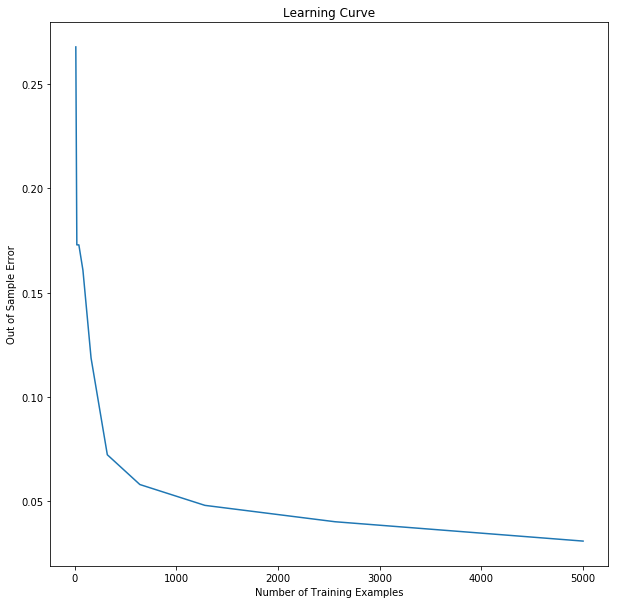

In [127]:
plt.figure(figsize = (10, 10))
plt.plot(nexamples, error)
plt.title('Learning Curve')
plt.ylabel('Out of Sample Error')
plt.xlabel('Number of Training Examples')

In the above experiment, I chose to plot the out-of-sample error for different numbers of input examples (10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5000). Even before looking at the graph, it seems intuitive that, as we increase the number of examples upon which the classifier is trained, the better it gets. The plot above appears to validate this point. There appears to be a logarithmic decline in the error, with increased number of training examples. It can also be seen from the graph that, it still appears to tend to decrease further. This indicates that, there is more potential to refine the classifier further with even more training examples, and this would lead us to a better classifier.

## Part 3:  Data normalization 

In this section we will explore the effect of normalizing the data, focusing on normalization of features.  The simplest form of normalization is to scale each feature to be in the range [-1, 1].  We'll call this **scaling**.

Here's what you need to do:

  - Explain how to scale the data to be in the range [-1, 1].
  - Compare the accuracy of the perceptron with bias on the original data and the scaled version of the heart dataset.  Does one of them lead to better performance?  Explain why you think this happens.  
  - An alternative way of normalizing the data is to **standardize** it:  for each feature subtract the mean and divide by its standard deviation.  What can you say about the range of the resulting features in this case?  




# ANSWER: #

## 3.a. ##

In order to re-scale data into the range $[-1, 1]$, we can use the following formula on each data example:

$$x_{scaled} = \frac{2 (x - min(x))}{max(x) - min(x)} - 1$$

where, 

* $x$ - original data
* $x_{scaled}$ - value of the scaled data
* $min(x)$ - data example with the least value in the dataset
* $max(x)$ - data example with the largest value in the dataset

Let us write a function in Python for this. The function below takes in a 1-D dataset, and scales the values between -1 and 1.

In [255]:
a = np.array([1,2,3,4,5,6,7,8,9])
def rescale(arr):
    new = np.array([])
    min = np.amin(a)
    max = np.amax(a)
    for i in arr:
        x = ((2*(i - min))/(max - min)) - 1
        new = np.append(new, x)
    return new

rescale(a)

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ])

## 3.b. ##

Let us first look at the error in the case of the unscaled dataset.

## Unscaled##

In [248]:
# Read in unscaled data.
data = np.genfromtxt("processed.cleveland.data", delimiter = ",")
#REMOVE NANS
data = data[~np.isnan(data).any(axis=1)]
#FIRST STEP IS TO EXTRACT THE LAST COLUMN (TARGET)
outdata = data[:,-1]
# PROCESS INTO -1 AND 1
# TARGET OUTPUTS
outdata[outdata > 0] = -1
outdata[outdata == 0] = 1
# INPUTS
indata = np.delete(data, -1, 1)
X = indata
y = outdata

In [249]:
# Split into training and testing datasets (80 - 20).
nRows = X.shape[0]
nTrain = int(round(0.8*nRows)) 
nTest = nRows - nTrain
# Shuffle row numbers
rows = np.arange(nRows)
np.random.shuffle(rows)
trainIndices = rows[:nTrain]
testIndices = rows[nTrain:]

Xtrain = X[trainIndices, :]
ytrain = y[trainIndices]
Xtest = X[testIndices, :]
ytest = y[testIndices]

In [242]:
# Calculate out of sample error
p = Perceptron()
unscaledError = outSample(p, Xtrain, ytrain, Xtest, ytest)
unscaledError

0.4406779661016949

Now, we shall use the rescale function defined above, to scale the heart dataset such that all input values are between -1 and 1. 

## Scaled##

In [258]:
# Scale the inputs
for i in range(len(X[0])):
    # Scale column wise
    col = X[:, i]
    scaledcol = rescale(col)
    print(scaledcol)
    # Update the column value.
    X[:, i] = scaledcol

[-1.60253906 -1.59863281 -1.59863281 -1.62792969 -1.62402344 -1.609375
 -1.60351562 -1.60839844 -1.60253906 -1.61230469 -1.60839844 -1.609375
 -1.609375   -1.62109375 -1.61328125 -1.60839844 -1.6171875  -1.61132812
 -1.6171875  -1.61621094 -1.6015625  -1.60742188 -1.60742188 -1.60742188
 -1.60546875 -1.61523438 -1.60742188 -1.59960938 -1.62207031 -1.625
 -1.59667969 -1.60546875 -1.6015625  -1.60644531 -1.62109375 -1.62304688
 -1.62207031 -1.60839844 -1.61035156 -1.60449219 -1.60058594 -1.625
 -1.59472656 -1.60644531 -1.60449219 -1.60742188 -1.61425781 -1.61523438
 -1.60058594 -1.61230469 -1.62402344 -1.60058594 -1.62109375 -1.62109375
 -1.60546875 -1.61132812 -1.61523438 -1.62402344 -1.61132812 -1.61425781
 -1.61425781 -1.61914062 -1.60742188 -1.61132812 -1.61132812 -1.60546875
 -1.60546875 -1.61132812 -1.60644531 -1.61914062 -1.60058594 -1.59863281
 -1.60351562 -1.60058594 -1.62109375 -1.60058594 -1.60546875 -1.61425781
 -1.6171875  -1.60742188 -1.62011719 -1.61230469 -1.62597656 -1.5

In [246]:
# Split into training and testing datasets (80 - 20).
nRows = X.shape[0]
nTrain = int(round(0.8*nRows)) 
nTest = nRows - nTrain
# Shuffle row numbers
rows = np.arange(nRows)
np.random.shuffle(rows)
trainIndices = rows[:nTrain]
testIndices = rows[nTrain:]

Xtrain = X[trainIndices, :]
ytrain = y[trainIndices]
Xtest = X[testIndices, :]
ytest = y[testIndices]

In [247]:
# Calculate out of sample error
p = Perceptron()
scaledError = outSample(p, Xtrain, ytrain, Xtest, ytest)
scaledError

0.288135593220339

From the above two experiments, it appears that the classifier has done better on the scaled dataset, than on the unscaled dataset. This is indicated by the fact that, the unscaled dataset yeilds an out-of-sample error of around 0.559, but the scaled dataset only yeilds an error value of 0.338. 

The classifier on the scaled dataset performs better, due to the fact that, by scaling feature values, we ensure that features with large magnitude values do not have too much undue influence on the weight vector. For example, a feature measuring human height would obviously have a larger magnitude than a feature measuring weight. By normalization, we remove this unwanted effect from the features. 

# 3.c. 

An implementation of the standardization function has been provided below.

In [223]:
def standardize(X):
    for i in range(len(X[0])):
        col = X[:, i]
        # Find mean
        mean = np.mean(col)
        # Find SD
        sd = np.std(col)
        # Loop through feature, updating each value.
        for j in range(len(X)):
            X[j,i] = (X[j,i] - mean)/sd
    return X
    
X = standardize(X)
X

array([[ 0.93618065,  0.69109474, -2.24062879, ...,  2.26414539,
        -0.72197605,  0.65587737],
       [ 1.3789285 ,  0.69109474,  0.87388018, ...,  0.6437811 ,
         2.47842525, -0.89422007],
       [ 1.3789285 ,  0.69109474,  0.87388018, ...,  0.6437811 ,
         1.41162482,  1.17257652],
       ...,
       [ 1.48961547,  0.69109474,  0.87388018, ...,  0.6437811 ,
         1.41162482,  1.17257652],
       [ 0.27205887,  0.69109474,  0.87388018, ...,  0.6437811 ,
         0.34482438,  1.17257652],
       [ 0.27205887, -1.44697961, -1.20245913, ...,  0.6437811 ,
         0.34482438, -0.89422007]])

Standardization normalizes the data around the mean value, instead of a specified range. The range of the features appear to be significantly reduced, through this process. 

### Your Report

Answer the questions in the cells reserved for that purpose.

Mathematical equations should be written as LaTex equations; the assignment contains multiple examples of both inline formulas (such as the one exemplifying the notation for the norm of a vector $||\mathbf{x}||$ and those that appear on separate lines, e.g.:

$$
||\mathbf{x}|| = \sqrt{\mathbf{x}^T \mathbf{x}}.
$$



### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the plots and results in your notebook.


### Grading 

Here is what the grade sheet will look like for this assignment.  A few general guidelines for this and future assignments in the course:

  * Your answers should be concise and to the point.  We will take off points if that is not the case.
  * Always provide a description of the method you used to produce a given result in sufficient detail such that the reader can reproduce your results on the basis of the description.  You can use a few lines of python code or pseudo-code.


Grading sheet for the assignment:

```
Part 1:  60 points.
(30 points):  Correct implementation of the classifiers
(15 points):  Good protocol for evaluating classifier accuracy; results are provided in a clear and concise way
(15 points):  Discussion of the results

Part 2:  20 points.
(15 points):  Learning curves are correctly generated and displayed in a clear and readable way
( 5 points):  Discussion of the results

Part 3:  20 points.
( 5 points):  How to perform data scaling
(10 points):  Comparison of normalized/raw data results; discussion of results
( 5 points):  Range of features after standardization
```


Grading will be based on the following criteria:

  * Correctness of answers to math problems
  * Math is formatted as LaTex equations
  * Correct behavior of the required code
  * Easy to understand plots 
  * Overall readability and organization of the notebook
  * Effort in making interesting observations where requested.
  * Conciseness.  Points may be taken off if the notebook is overly 
  